<a href="https://colab.research.google.com/github/Negfir/Deep-Learning-HWs/blob/main/HW1/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/Dataset'


/content/gdrive/My Drive/Dataset


epoch=0-----Training Loss= 0.47649637827054625
epoch=0-----Validation Loss= 0.44304064637754154
epoch=1-----Training Loss= 0.2723537683696439
epoch=1-----Validation Loss= 0.2056763936279853
epoch=2-----Training Loss= 0.21050425342216136
epoch=2-----Validation Loss= 0.19389164562092334
epoch=3-----Training Loss= 0.17729293647327415
epoch=3-----Validation Loss= 0.1476159155140221
epoch=4-----Training Loss= 0.15360898060142944
epoch=4-----Validation Loss= 0.1495843061511646
epoch=5-----Training Loss= 0.13761860187018266
epoch=5-----Validation Loss= 0.1707121322932185
epoch=6-----Training Loss= 0.12198007226853337
epoch=6-----Validation Loss= 0.12558301751007372
epoch=7-----Training Loss= 0.11287595296929274
epoch=7-----Validation Loss= 0.1337888898769015
epoch=8-----Training Loss= 0.10348255542817679
epoch=8-----Validation Loss= 0.206517754535169
epoch=9-----Training Loss= 0.09811716722236836
epoch=9-----Validation Loss= 0.19321218945762225
epoch=10-----Training Loss= 0.09460657539652219


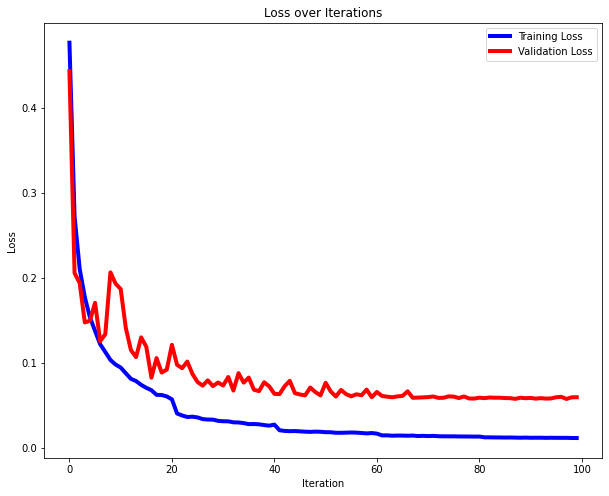

In [11]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Training Data
#We first load the data in
x_train = pd.read_csv('data/training_set.csv', header=None).values
y_train = pd.read_csv('data/training_labels_bin.csv', header=None).values
x_val = pd.read_csv('data/validation_set.csv', header=None).values
y_val = pd.read_csv('data/validation_labels_bin.csv', header=None).values
N = len(x_train)
x_train.shape

#to calculate the run time
start = time.time()
#setting the seed in order to have reproducible results 
torch.manual_seed(6)

num_feats = x_train.shape[1]
n_out = y_train.shape[1]

# hyperparameters (you may change these)
eta = 0.1 # intial learning rate
gamma = 0.5 # multiplier for the learning rate
stepsize = 20 # epochs before changing learning rate
threshold = 0.04 # stopping criterion
test_interval = 1 # number of epoch before validating
max_epoch = 100


# Define Architecture of NN
# [ ] Intialize your network weights and biases here

#Network size
inputSize = x_train.shape[1]
outputSize = 3
hidden_1_Size = 36
hidden_2_Size = 12

# Initializing weights and biases with random values
W1= np.random.rand(inputSize, hidden_1_Size)
W1 = 1 - (W1*2)
b1 = np.random.randn(hidden_1_Size)

W2= np.random.rand(hidden_1_Size, hidden_2_Size)
W2 = 1 - (W2*2)
b2 = np.random.randn(hidden_2_Size)

W3= np.random.rand(hidden_2_Size, outputSize)
W3 = 1 - (W3*2)
b3 = np.random.randn(outputSize)

def sigmoid(x):
    return 1/(1+np.exp(-x))

#the derivative of sigmoid function
def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

# function for permforming the forward pass and predict the labels based on the trained parameters
def predict(x):
    z1_ = np.matmul(x,W1)+b1
    h1_ = sigmoid(z1_)
    z2_ = np.matmul( h1_, W2)+b2
    h2_ = sigmoid(z2_)
    z3_ = np.matmul(h2_, W3)+b3
    y_pred = sigmoid(z3_)
    # y_pred = np.where(y_pred_ > 0.5, 1, 0) #uncomment for finding accuracy only (not needed)
    return y_pred

# function to calculate the accuracy of prediction (in case needed, first have to uncomment the line in predict() function)
def accuracy(pred, y):
    acc=0
    for i,x in enumerate(pred):
      acc += np.sum(x == y[i])/float(len(y[i]))
    return acc/len(pred)


#initialization of lists containing training and validation loss
training_losses = []
val_loss=[]

for epoch in range(0, max_epoch):
    
    order = np.random.permutation(N) # shuffle data
    
    sse = 0
    sse_val = 0
    for n in range(0, N):
        #get the indexes of that order
        idx = order[n]

        # get a sample (batch size=1)
        x_in = x_train[idx]
        y = y_train[idx]

        # [ ] do the forward pass here
        # hint: you need to save the output of each layer to calculate the gradients later
        # the activation functions are said to be set to sigmoid
        z1 = np.matmul(x_in,W1)+b1
        h1 = sigmoid(z1)
        z2 = np.matmul( h1, W2)+b2
        h2 = sigmoid(z2)
        z3 = np.matmul(h2, W3)+b3
        y_pred = sigmoid(z3)
    
        # [ ] compute error and gradients here
        # hint: don't forget the chain rule

        #output layer gradients
        dsse_dy = 2*(y_pred - y)
        dy_dz3 = sigmoid_der(z3)
        dsse_dz3 = dsse_dy * dy_dz3
        dz3_dw3 = h2
        dsse_dw3 = np.dot(dsse_dz3.reshape(len(dsse_dz3),1),dz3_dw3.reshape(1,len(dz3_dw3)))
        dsse_db3 = np.dot(dsse_dy,dy_dz3)

        #hidden2 layer gradients
        dz3_dh2 = W3
        dsse_dh2 = np.dot(dz3_dh2,dsse_dz3)
        dh2_dz2 = sigmoid_der(z2)
        dsse_dz2 = dh2_dz2 * dsse_dh2
        dz2_dw2 = h1
        dsse_dw2 = np.dot(dsse_dz2.reshape(len(dsse_dz2),1),dz2_dw2.reshape(1,len(dz2_dw2)))
        dsse_db2 = dh2_dz2 * dsse_dh2

        #hidden1 layer gradients
        dz2_dh1 = W2
        dsse_dh1 = np.dot(dz2_dh1,dsse_dz2)
        dh1_dz1 = sigmoid_der(z1)
        dsse_dz1 = dh1_dz1 * dsse_dh1
        dz1_dw1 = x_in
        dsse_dw1 = np.dot(dsse_dz1.reshape(len(dsse_dz1),1),dz1_dw1.reshape(1,len(dz1_dw1)))
        dsse_db1 = dh1_dz1 * dsse_dh1



        # [ ] update weights and biases here
        # update weights and biases in output layer using the update rule

        #updating weights and biases of hidden1 layer 
        W1 -= eta * dsse_dw1.T
        b1 -= eta * dsse_db1

        #updating weights and biases of hidden2 layer 
        W2 -= eta * dsse_dw2.T
        b2 -= eta * dsse_db2

        #updating weights and biases of output layer 
        W3 -= eta * dsse_dw3.T
        b3 -= eta * dsse_db3


        sse += np.sum((y_pred - y)**2) #sum of squared_error
    training_losses.append(sse/len(y_train)) # traininng loss is the mean of squared errors

    #Accuracy
    acc = accuracy(predict(x_train),y_train)
    print(f"epoch={epoch}-----Training Loss= {sse/len(y_train)}")
    

    train_mse = sse/len(x_train)

    if epoch % test_interval == 0: 
        # [ ] test on validation set here
        acc_val = accuracy(predict(x_val),y_val)
        sse_val = np.sum((predict(x_val) - y_val)**2)
        print(f"epoch={epoch}-----Validation Loss= {sse_val/len(y_val)}")
        val_loss.append(sse_val/len(y_val))
    
        # if termination condition is satisfied, exit
        # we have set the nnumber of iterations set to 100, threshold set to 0.04 
        # so the number of iterations reaches 100 before the validation loss becomes less thann 0.04
        if (sse_val/len(y_val)) < threshold:
            break

    # at some steps we update the learning rate
    if epoch % stepsize == 0 and epoch != 0:
        eta = eta*gamma
        print('Changed learning rate to lr=' + str(eta))


#plot traininng loss and validation loss versus number of iterations
# as you can see the final validation loss is 0.063  and our training loss is 0.009 which is near zero
# the raining and validation loss are constant after some iteration so we can conclude that the training has stopped
# at first the validationn loss is lower tha training loss but this quickly changes annd the validation loss becomes higher than training loss.
plt.figure(figsize=(10,8))
plt.plot(training_losses[0:], lw=4, color='blue', label='Training Loss')
plt.plot(val_loss[0:], lw=4, color='red', label='Validation Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()